In [1]:
from standardInclude import *

Welcome to JupyROOT 6.12/06
For interactive plots, run: setint()
To return to non-interactive plots (default state), run: noint()


### Start by defining some helper functions and constants

In [2]:
#only one calo at a time for simplicity
caloToPlot = 19
allFitResults = []

In [3]:
def getWidths(h):
    '''
    Takes a TH2 of positions vs. time and returns a vector of time and standard deviations
    '''
    means = []
    widths = []
    times = []
    meanErrs = []
    widthErrs = []
    for bini in range(1,h.GetNbinsX()+1):
        hi = h.ProjectionY("", bini, bini)
        time = h.GetXaxis().GetBinCenter(bini)
        times.append(time)
        means.append(hi.GetMean(1))
        widths.append(hi.GetStdDev(1))
        meanErrs.append(hi.GetMean(11))
        widthErrs.append(hi.GetStdDev(11))

    dicti = {'times':times, 'widths':widths, 'widthErrs':widthErrs, 'means':means, 'meanErrs':meanErrs}
    #return(times, widths, widthErrs, means, meanErrs) 
    return dicti

In [4]:
def randomizeTimes( x, p=[None] ):
    inputtime = x[0]
    time = inputtime
    
    w0 = 2.6094;
    A = 2.80;
    tauA = 56.6;
    B = 6.18;
    tauB = 6.32;
    
    wCBO =  (w0 - (A/(tauA)) * r.TMath.Exp(-time/(1000.0*tauA)) - (B/(tauB)) * r.TMath.Exp(-time/(tauB*1000.0)) ); #MHz
    wa =  r.TMath.TwoPi() * 0.2291; #MHZ
    wc =  r.TMath.TwoPi() / 0.14919; #MHz

    factor = 1.0;
    wY = factor * (wCBO) * r.TMath.Sqrt( (2 * wc / (factor * wCBO)) -1.0 ) ;
    wVW = wc - (2.0 * wY);

    TCBO = r.TMath.TwoPi() / wCBO;
    Ta = r.TMath.TwoPi() / wa;
    TVW = r.TMath.TwoPi() / wVW;
    TY = r.TMath.TwoPi() / wY;
    T_diff= r.TMath.TwoPi()/(wCBO-wa);
    
    #time += (rng->Uniform()-0.5)*(Ta*1000.0);// w_a 4365
    timestorandomize = [
                        Ta, 
                        TCBO, 
                        TVW, 
                        TY, 
                        T_diff,
                       ]
    
    for periodi in timestorandomize:
        #time += (np.random.random() - 0.5)*(periodi)
        time += -1*np.abs((np.random.random() - 0.5))*(periodi)
    #print(inputtime, time, TCBO, Ta)
    
    #print(time, time/1000.)
    return time

---

# Matched Tracks

### Lets begin with the calo-matched tracks for the endgame, using default parameters

In [5]:
t = r.TChain("tree")
t.Add("./data/sam_trees_endgame/trackAndTrackCaloTrees_17159.root ")
#t.Add("./data/sam_trees_endgame/*root")

1

In [6]:
t.Scan("clusterCaloNum","clusterCaloNum > "+str(caloToPlot-1),"",10)

5

***********************************
*    Row   * Instance * clusterCa *
***********************************
*        1 *        0 *        19 *
*        2 *        0 *        19 *
*        3 *        0 *        19 *
*        5 *        0 *        19 *
*        6 *        0 *        19 *
***********************************
==> 5 selected entries


In [7]:
%%time

matchedTracks_yCaloTracks_vs_yCaloTracker_vs_Time = r.TH3I(
            "matchedTracks_yCaloTracks_vs_yCaloTracker_vs_Time", 
            'Tracker Calo y vs. Cluster Calo y vs. Time; Cluster Time [#mus]; Beam y from tracker [mm]; Calo y from clusters [mm]',
            4698, 0, 700,
            200, -100, 100,
            200, -100,100
           )

t.Draw("clusterY:decayVertexPosY:clusterTime/1000.>>matchedTracks_yCaloTracks_vs_yCaloTracker_vs_Time",
       "clusterCaloNum > "+str(caloToPlot-1), # == not working here, not sure why.
       "goff")

CPU times: user 6.78 s, sys: 30.6 s, total: 37.4 s
Wall time: 42.2 s


80790

In [8]:
print("Number of Matched Tracks:", matchedTracks_yCaloTracks_vs_yCaloTracker_vs_Time.GetEntries())

Number of Matched Tracks: 80790.0


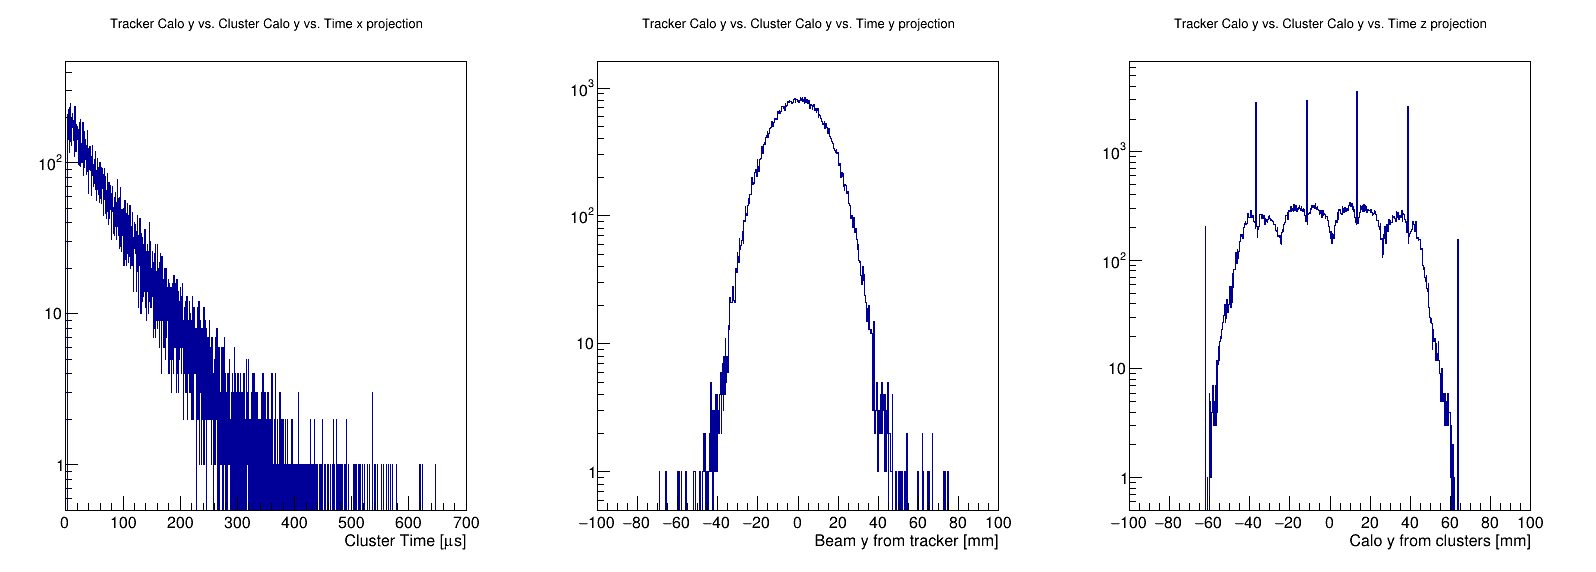

In [9]:
c = r.TCanvas("c","c",1600,600)
c.Divide(3,1)
for i, axi in enumerate(["x","y","z"]):
    c.cd(i+1)
    matchedTracks_yCaloTracks_vs_yCaloTracker_vs_Time.Project3D(axi).Draw()
    r.gPad.SetLogy()
c.Draw()

### Beam motion vs. time

In [11]:
tlow = 5
thigh = 600

func = r.TF1("func","[0] - [1]/(TMath::Exp([2]*x)) + [3]*(x)",tlow,thigh)
func.SetParNames("C", "A", "#tau", "m")
paramVec = [1,10,1,-0.0001,10]

#Beam motion vs. time
widthDict = getWidths(matchedTracks_yCaloTracks_vs_yCaloTracker_vs_Time.Project3D("yx"))

for i,xi in enumerate(paramVec):
    func.SetParameter(i,xi)
fitresult = fitVector(widthDict['times'], widthDict['widths'], func, None, widthDict['widthErrs'])
allFitResults.append(fitresult)

/home/jlab/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/jlab/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


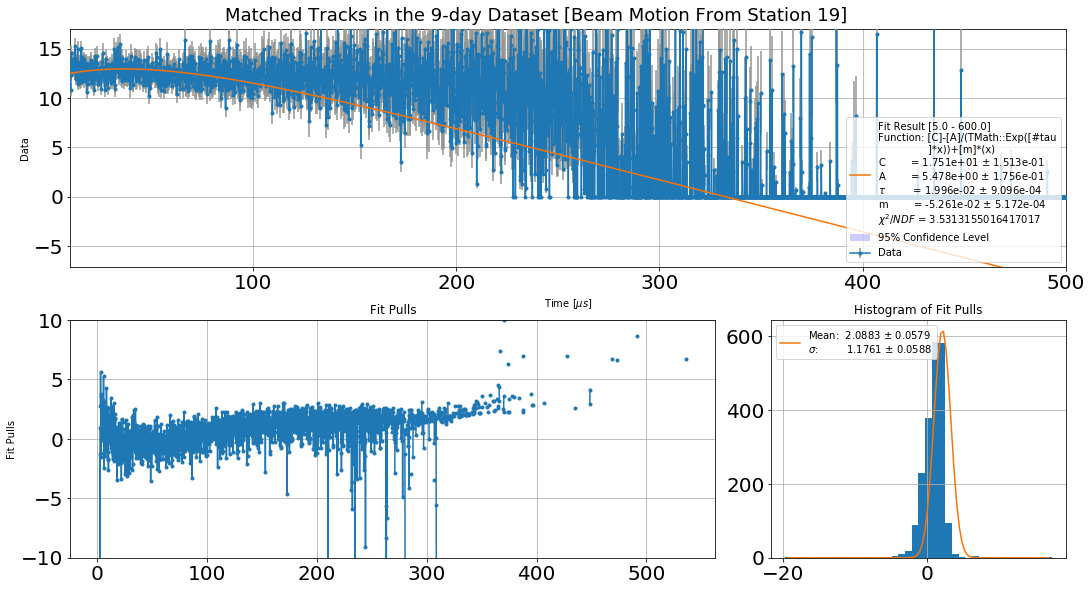

In [12]:
fig,ax = fitresult.draw("Matched Tracks in the 9-day Dataset [Beam Motion From Station "+str(caloToPlot)+"]", 
                        yrange=[None, [-10,10]], fmt=".-")
#ax[0].set_ylim(-2,2)
ax[0].set_xlim(10,500)
ax[0].set_xlabel(r"Time [$\mu s$]")


plt.show()

### Calo face motion vs. time

In [86]:
tlow = 5
thigh = 600

func = r.TF1("func","[0] - [1]/(TMath::Exp([2]*x)) + [3]*(x)",tlow,thigh)
func.SetParNames("C", "A", "#tau", "m")
paramVec = [1,10,1,-0.0001,10]

#Beam motion vs. time
widthDict = getWidths(matchedTracks_yCaloTracks_vs_yCaloTracker_vs_Time.Project3D("zx"))

for i,xi in enumerate(paramVec):
    func.SetParameter(i,xi)
fitresult = fitVector(widthDict['times'], widthDict['widths'], func, None, widthDict['widthErrs'])
allFitResults.append(fitresult)

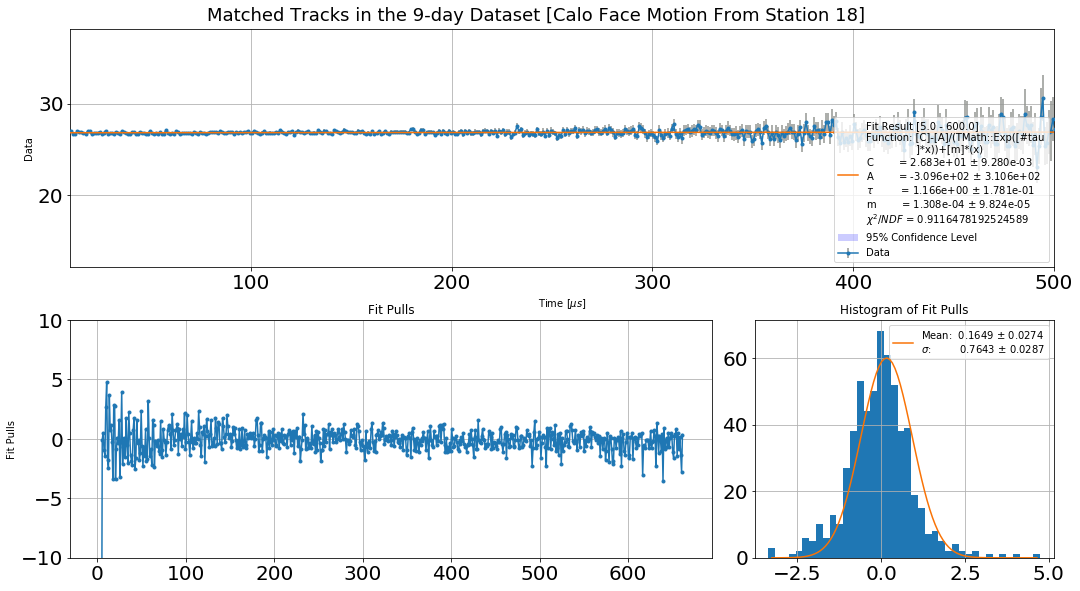

In [89]:
fig,ax = fitresult.draw("Matched Tracks in the 9-day Dataset [Calo Face Motion From Station "+str(caloToPlot)+"]", 
                        yrange=[None, [-10,10]], fmt=".-")
#ax[0].set_ylim(-2,2)
ax[0].set_xlim(10,500)
ax[0].set_xlabel(r"Time [$\mu s$]")


plt.show()

---

# Extrapolate out the position without the radial field

In [64]:
%%time

#extrapolate out position ignoring radial field
vec = []

for i, e in enumerate(t):
    if(i > 10000):
        break
        
    initialMomentum = -1*e.decayVertexMomY  #From James/Joe: Backwards extrapolation flips momentum
    initialPosition = e.decayVertexPosY
    
    finalPosition = e.caloVertexPosY
    
    deltaT = e.caloVertexTime -  e.decayTime
    muonMass = 105.66# MeV
    electronMass = 0.511 #MeV
    speedOfLight = 299.8 #mm/ns
    gamma = 29.3 #just assume magic momentum
    
    #deltaY = deltaT * (initialMomentum / muonMass)*21.1 #mm
    deltaY = (deltaT * initialMomentum)/(gamma * electronMass)
    deltaY_tracker = finalPosition - initialPosition
    
    
    ding = [initialMomentum, initialPosition, deltaT, finalPosition, deltaY_tracker, deltaY, e.clusterCaloNum[0]]
    vec.append(ding)
    #print(ding)
    
names = ['initialMomentum', 'initialPosition', 'deltaT', 'finalPosition', 'deltaY_tracker', 'deltaY', 'calo'] 
df = pandas.DataFrame(vec, columns=names)
df.head()

CPU times: user 859 ms, sys: 203 ms, total: 1.06 s
Wall time: 1.4 s


,initialMomentum,initialPosition,deltaT,finalPosition,deltaY_tracker,deltaY,calo
0,23.070845,1.250078,9.546875,40.566185,39.316107,14.710797,13
1,-29.536274,5.789762,8.953125,-33.739719,-39.529481,-17.662079,19
2,-32.424213,8.274569,10.070312,-46.543423,-54.817991,-21.808404,19
3,15.195882,-3.367542,4.796875,18.256310,21.623851,4.868507,13
4,-36.279453,10.943600,4.597656,-41.999252,-52.942852,-11.140603,13


In [ ]:
df = df.loc[df['calo'] == caloToPlot]
df.head()

In [66]:
func =r.TF1("func","pol1",-100,100,2)
func.SetParameters(0,-1)
fit = fitVector(df['deltaY_tracker'], df['deltaY'], func )

#fit.draw(do_pulls=False, fmt=".")
#plt.show()

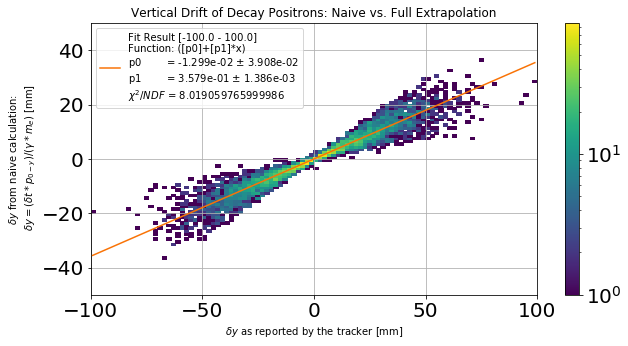

In [69]:
fig,ax = plt.subplots(figsize=(10,5))
plt.hist2d(df['deltaY_tracker'], df['deltaY'],bins=(100,100), range=[[-100,100],[-50,50]],
          norm = matplotlib.colors.LogNorm()
          )
fit.drawFitResult(ax)
#fit.drawConfidenceIntervals(ax)
plt.grid()
plt.colorbar()
plt.xlabel(r"$\delta y$ as reported by the tracker [mm]")
plt.ylabel(r"$\delta y$ from naive calculation:"+"\n"+r" $\delta y = (\delta t * p_{0-y}) / (\gamma * m_{e} )$ [mm]")
plt.title("Vertical Drift of Decay Positrons: Naive vs. Full Extrapolation")
plt.legend()
plt.show()

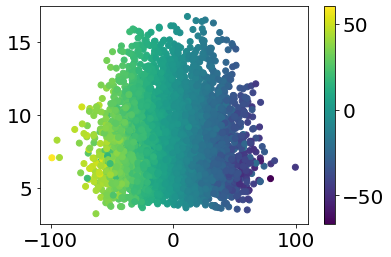

In [68]:
plt.scatter(df['initialPosition']- df['finalPosition'], df['deltaT'], c=df['initialMomentum'])
plt.colorbar()
plt.show()

---

### Now lets load up the endgame clusters by themselves

In [10]:
f = r.TFile("/home/jlab/g-2/slidingScaleFits/data/EndGame4042BFinalRandNon_pileup_corrected.root")
f.ls()

TFile**		/home/jlab/g-2/slidingScaleFits/data/EndGame4042BFinalRandNon_pileup_corrected.root	
 TFile*		/home/jlab/g-2/slidingScaleFits/data/EndGame4042BFinalRandNon_pileup_corrected.root	
  KEY: TDirectoryFile	clustersAndCoincidences;1	clustersAndCoincidences
